# In this notebook we prepare building a SIMPUT of Jupiter

In particular, we will create an extended source representing Jupiter based on a Chandra observation, which sees both emission from the planet as a whole as well as auroral emission.

In [1]:
# imports
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import scipy.ndimage as ndimage

from matplotlib.colors import LogNorm
%matplotlib inline

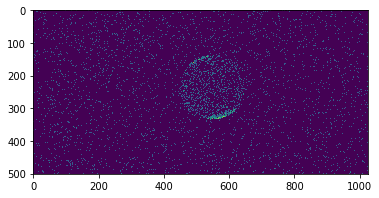

In [2]:
# load and plot the data
imgfile = "JupiterACIS2011Oct2.fits"

raw_img = fits.open(imgfile)[0].data

plt.imshow(raw_img+1, norm=LogNorm())

We need to separate background, the planet and the auroral region.

One way to do it would be by counts, for instance finding the region within which the countrate is greater than some value.

# Planet by eye, aurorae by convolution & filtering

For the planet itself, though, we can probably fit by eye, using an ellipsis.

In [3]:
center = [236, 550]
radius = 107 # both in pixels

axis_angle = 115 * np.pi/180
polar_ratio = 66.854 / 71.492
planet_mask = np.zeros_like(raw_img)

for ii in range(raw_img.shape[0]):
    for jj in range(raw_img.shape[1]):
        dx = ii-center[0]
        dy = jj-center[1]
        # get distance along equatorial and polar axis
        d_equat = dx*np.cos(axis_angle) + dy*np.sin(axis_angle)
        d_polar = -dx*np.sin(axis_angle) + dy*np.cos(axis_angle)
        if (np.sqrt((d_equat)**2 + (d_polar/polar_ratio)**2) < radius):
            planet_mask[ii,jj] = 1

(350, 100)

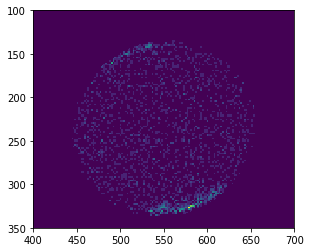

In [4]:
plt.imshow(planet_mask*raw_img)
#plt.imshow(planet_mask)
plt.xlim(400, 700)
plt.ylim(350, 100)

Let's say this mask gives us roughly the planet. Now, we need to extract the auroral regions.

To extract the auroral regions, we could so some form of blurring, follwed by thresholding.

In [5]:
# convolution: do a Gaussian filter
convimg = ndimage.gaussian_filter(raw_img, 4, mode="wrap")

# aurorae have to be inside the planet!
convimg *= planet_mask

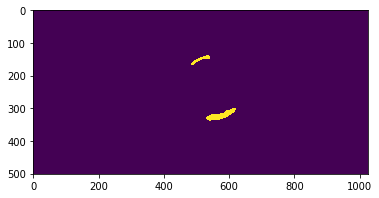

In [6]:
# now do a simple thresholding - where the countrate exceeds our threshold, we have aurorae
aurora_mask = convimg > 0.6

plt.imshow(aurora_mask)
#plt.xlim(400,700)
#plt.ylim(100, 400)

A rough estimate of surface brightness is the sum of the pixel values in a given region, divided by the nr of pixel in that region.

i.e. the mean of all pixels in that region:

In [7]:
print("Rough surface brightnesses (cts per pixel):")

print("Full image:", np.mean(raw_img))
print("Background only:", np.mean(raw_img[planet_mask != True]))
print("")
print("Full Planet:", np.mean(raw_img[planet_mask == True]))
print("Auroral Region:", np.mean(raw_img[aurora_mask == True]))
print("Planet without aurorae:", np.mean(raw_img[planet_mask * np.logical_not(aurora_mask) == True]))

Rough surface brightnesses (cts per pixel):
Full image: 0.071611166
Background only: 0.05515322

Full Planet: 0.30665636
Auroral Region: 1.2284216
Planet without aurorae: 0.24537095


(350, 100)

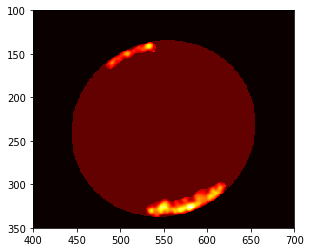

In [9]:
# "Reconstructed" image: Make the disk have a flat brightness, then add the aurorae on top of it

# intensity of the flat disk
flat_intens = np.mean(raw_img[(planet_mask * np.logical_not(aurora_mask)) == True])

# blur the auroral contribution
recons = (planet_mask) * flat_intens + ndimage.gaussian_filter((raw_img-flat_intens), 2)*aurora_mask*planet_mask

plt.imshow(recons+1, vmax=5, cmap="hot", norm=LogNorm())
plt.xlim(400, 700)
plt.ylim(350, 100)
#plt.savefig("Recons_1.png")

Now let's try and create images for the simput

We'll create two image extensions - one for the aurorae, and one for the planet.

Both will be subsets of the original image

In [10]:
x0=100; x1=350
y0=400; y1=700
disk_img = (planet_mask * flat_intens)[x0:x1, y0:y1]
aurora_img = (ndimage.gaussian_filter((raw_img-flat_intens), 2)*aurora_mask)[x0:x1, y0:y1]

In [11]:
# need WCS keys from original image
orig_header = fits.open(imgfile)[0].header

In [12]:
# Disk image
disk_hdu = fits.ImageHDU(data=disk_img)
disk_hdu.name = "DISK"

# copy the header, but adjust the crpix's!
disk_hdu.header["RADESYS"] = orig_header["RADESYS"]
disk_hdu.header["EQUINOX"] = orig_header["EQUINOX"]
disk_hdu.header["CTYPE1"] = orig_header["CTYPE1"]
disk_hdu.header["CTYPE2"] = orig_header["CTYPE2"]
disk_hdu.header["CRVAL1"] = orig_header["CRVAL1"]
disk_hdu.header["CRVAL2"] = orig_header["CRVAL2"]
disk_hdu.header["CUNIT1"] = orig_header["CUNIT1"]
disk_hdu.header["CUNIT2"] = orig_header["CUNIT2"]
disk_hdu.header["CRPIX1"] = orig_header["CRPIX1"] - y0
disk_hdu.header["CRPIX2"] = orig_header["CRPIX2"] - x0
disk_hdu.header["CDELT1"] = orig_header["CD1_1"]
disk_hdu.header["CDELT2"] = orig_header["CD2_2"]

In [13]:
# Aurora image
aurora_hdu = fits.ImageHDU(data=aurora_img)
aurora_hdu.name = "AURORAE"

# copy the header, but adjust the crpix's!
aurora_hdu.header["RADESYS"] = orig_header["RADESYS"]
aurora_hdu.header["EQUINOX"] = orig_header["EQUINOX"]
aurora_hdu.header["CTYPE1"] = orig_header["CTYPE1"]
aurora_hdu.header["CTYPE2"] = orig_header["CTYPE2"]
aurora_hdu.header["CRVAL1"] = orig_header["CRVAL1"]
aurora_hdu.header["CRVAL2"] = orig_header["CRVAL2"]
aurora_hdu.header["CUNIT1"] = orig_header["CUNIT1"]
aurora_hdu.header["CUNIT2"] = orig_header["CUNIT2"]
aurora_hdu.header["CRPIX1"] = orig_header["CRPIX1"] - y0
aurora_hdu.header["CRPIX2"] = orig_header["CRPIX2"] - x0
aurora_hdu.header["CDELT1"] = orig_header["CD1_1"]
aurora_hdu.header["CDELT2"] = orig_header["CD2_2"]

In [14]:
hdulist = fits.HDUList(fits.PrimaryHDU())
hdulist.append(disk_hdu)
hdulist.append(aurora_hdu)

hdulist.writeto("emission_regions.img", overwrite=True)